In [65]:
import kagglehub
import os

# Download latest version
dataset = kagglehub.dataset_download("ashishsaxena2209/animal-image-datasetdog-cat-and-panda")

print(os.listdir(dataset))
print('Images download done.')

['animals', 'images']
Images download done.


In [66]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [67]:
dataset = os.path.join(dataset, "animals")
print(os.listdir(dataset))

['animals', 'images', 'dogs', 'panda', 'cats']


In [68]:
categories = os.listdir(dataset)

In [69]:
print(categories)

['animals', 'images', 'dogs', 'panda', 'cats']


In [70]:
print ([os.listdir(os.path.join(dataset, category)) for category in categories])

[['dogs', 'panda', 'cats'], ['cat.jpg', 'dog.jpg', 'panda.jpg'], ['dogs_00583.jpg', 'dogs_00683.jpg', 'dogs_00750.jpg', 'dogs_00652.jpg', 'dogs_00895.jpg', 'dogs_00686.jpg', 'dogs_00622.jpg', 'dogs_00291.jpg', 'dogs_00944.jpg', 'dogs_00082.jpg', 'dogs_00955.jpg', 'dogs_00309.jpg', 'dogs_00253.jpg', 'dogs_00416.jpg', 'dogs_00646.jpg', 'dogs_00463.jpg', 'dogs_00688.jpg', 'dogs_00732.jpg', 'dogs_00137.jpg', 'dogs_00602.jpg', 'dogs_00647.jpg', 'dogs_00976.jpg', 'dogs_00636.jpg', 'dogs_00226.jpg', 'dogs_00359.jpg', 'dogs_00684.jpg', 'dogs_00370.jpg', 'dogs_00676.jpg', 'dogs_00500.jpg', 'dogs_00716.jpg', 'dogs_00294.jpg', 'dogs_00041.jpg', 'dogs_00544.jpg', 'dogs_00124.jpg', 'dogs_00429.jpg', 'dogs_00279.jpg', 'dogs_00821.jpg', 'dogs_00957.jpg', 'dogs_00846.jpg', 'dogs_00843.jpg', 'dogs_00391.jpg', 'dogs_00519.jpg', 'dogs_00452.jpg', 'dogs_00618.jpg', 'dogs_00875.jpg', 'dogs_00381.jpg', 'dogs_00692.jpg', 'dogs_00917.jpg', 'dogs_00167.jpg', 'dogs_00122.jpg', 'dogs_00473.jpg', 'dogs_00625.jpg'

In [71]:
from tqdm import tqdm
training_data = [] # Initialize empty list to store processed images and labels

for category in categories: # Loop through each category folder
    category_path = os.path.join(dataset, category)
    class_label = categories.index(category)

    print(f"\nLoading {category} images...")
    for image_file in tqdm(os.listdir(category_path)):
        image_path = os.path.join(category_path, image_file)
        image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        training_data.append([image_array, class_label])

print(f"\nTotal samples loaded: {len(training_data)}")




Loading animals images...


100%|██████████| 3/3 [00:00<00:00, 1737.01it/s]



Loading images images...


100%|██████████| 3/3 [00:00<00:00, 342.84it/s]



Loading dogs images...


100%|██████████| 1000/1000 [00:02<00:00, 463.82it/s]



Loading panda images...


100%|██████████| 1000/1000 [00:04<00:00, 200.48it/s]



Loading cats images...


100%|██████████| 1000/1000 [00:02<00:00, 496.75it/s]


Total samples loaded: 3006


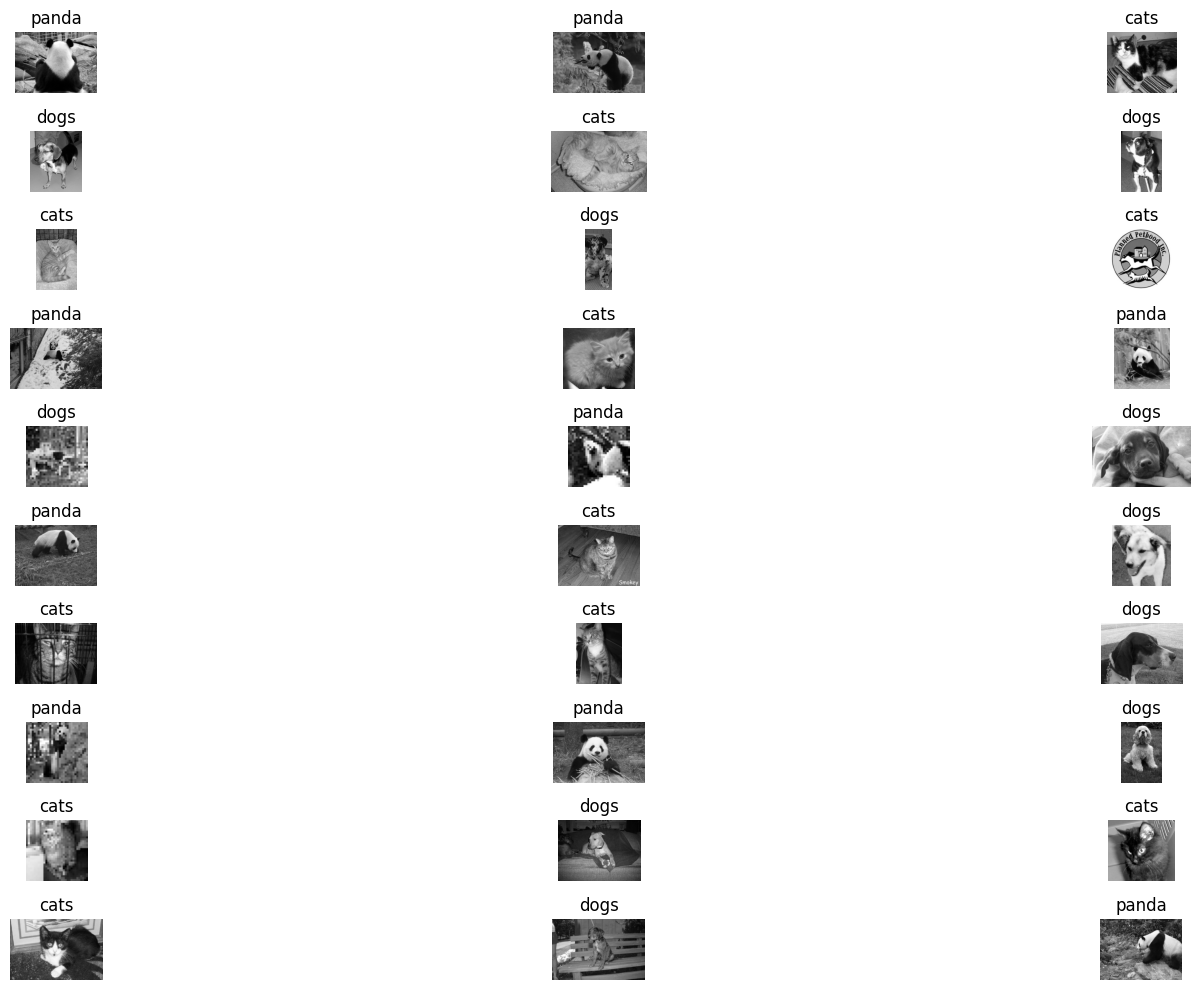

In [90]:
# Data Visualization
random.shuffle(training_data) # Shuffle the dataset to ensure random distribution
plt.figure(figsize=(20, 10))
for i in range(30): # Display first 30 images from the dataset
    plt.subplot(10, 3, i+1)
    plt.imshow(training_data[i][0], cmap='gray')
    plt.title(categories[training_data[i][1]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [73]:
f0 = training_data[0:600]
f1 = training_data[600:1200]
f2 = training_data[1200:1800]
f3 = training_data[1800:2400]
f4 = training_data[2400:3000]
folds = [f0, f1, f2, f3, f4]


In [74]:
def l1_dist(image1, image2): # Calculate Manhattan distance between two images
    if image1 is None or image2 is None:
        return float('inf')  # Return large distance for invalid images
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2): #Calculate Euclidean distance between two images
    if image1 is None or image2 is None:
        return float('inf')  # Return large distance for invalid images
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    return np.sqrt(np.sum((image1 - image2) ** 2))


In [75]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

top_filter = 20

In [76]:
def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []

    for valid in tqdm(valid_fold):
        temp_dist_list = []

        # Skip invalid validation images
        if valid[0] is None:
            continue

        for train in train_fold:
            # Skip invalid training images
            if train[0] is None:
                continue

            l1_distance = l1_dist(valid[0], train[0])
            l2_distance = l2_dist(valid[0], train[0])
            temp_dist_list.append([valid[1], train[1], {"l1": l1_distance, "l2": l2_distance}])

        if temp_dist_list:  # Only proceed if we have valid distances
            temp_dist_list.sort(key=by_l1_dist)
            l1_result.append(temp_dist_list[:top_filter])
            temp_dist_list.sort(key=by_l2_dist)
            l2_result.append(temp_dist_list[:top_filter])

    return [l1_result, l2_result]

In [77]:
k_range = 20 # Define range of k values to evaluate

def cal_accuracy(dist_result, dist_term):
    k_accuracies = []

    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)

            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1
            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class):
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1

        k_accuracies.append(img_accuracy/len(dist_result))

    return k_accuracies

In [79]:
from tqdm import tqdm
import numpy as np
import cv2

# 1. First clean the training data by removing invalid images
cleaned_training_data = []
for img, label in training_data:
    if img is not None and isinstance(img, np.ndarray):
        try:
            # Convert to grayscale if needed and resize
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (32, 32))
            cleaned_training_data.append([img, label])
        except:
            continue

print(f"Kept {len(cleaned_training_data)}/{len(training_data)} valid images")

# 2. Create numpy arrays from cleaned data
train_arrays = np.array([x[0] for x in cleaned_training_data])
train_labels = np.array([x[1] for x in cleaned_training_data])

# 3. Create folds using indices
n_samples = len(cleaned_training_data)
fold_size = n_samples // 5
folds = [list(range(i*fold_size, (i+1)*fold_size)) for i in range(5)]

# 4. Optimized cross-validation
dist_by_fold = []

for i in tqdm(range(5), desc="Cross-validation Folds"):
    valid_indices = folds[i]
    train_indices = [idx for fold_idx, fold in enumerate(folds)
                   if fold_idx != i for idx in fold]

    l1_results = []
    l2_results = []

    for valid_idx in tqdm(valid_indices, desc=f"Fold {i+1}", leave=False):
        valid_img = train_arrays[valid_idx]
        valid_label = train_labels[valid_idx]

        # Vectorized distance calculations
        diff = train_arrays[train_indices] - valid_img
        l1_dists = np.sum(np.abs(diff), axis=(1,2))
        l2_dists = np.sqrt(np.sum(diff**2, axis=(1,2)))

        # Get top 20 neighbors for each metric
        top_l1 = np.argsort(l1_dists)[:20]
        top_l2 = np.argsort(l2_dists)[:20]

        l1_results.append([
            [valid_label, train_labels[train_indices][idx], {"l1": float(l1_dists[idx])}]
            for idx in top_l1
        ])
        l2_results.append([
            [valid_label, train_labels[train_indices][idx], {"l2": float(l2_dists[idx])}]
            for idx in top_l2
        ])

    dist_by_fold.append([l1_results, l2_results])

Kept 3003/3006 valid images


Cross-validation Folds: 100%|██████████| 5/5 [00:44<00:00,  8.92s/it]


In [80]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

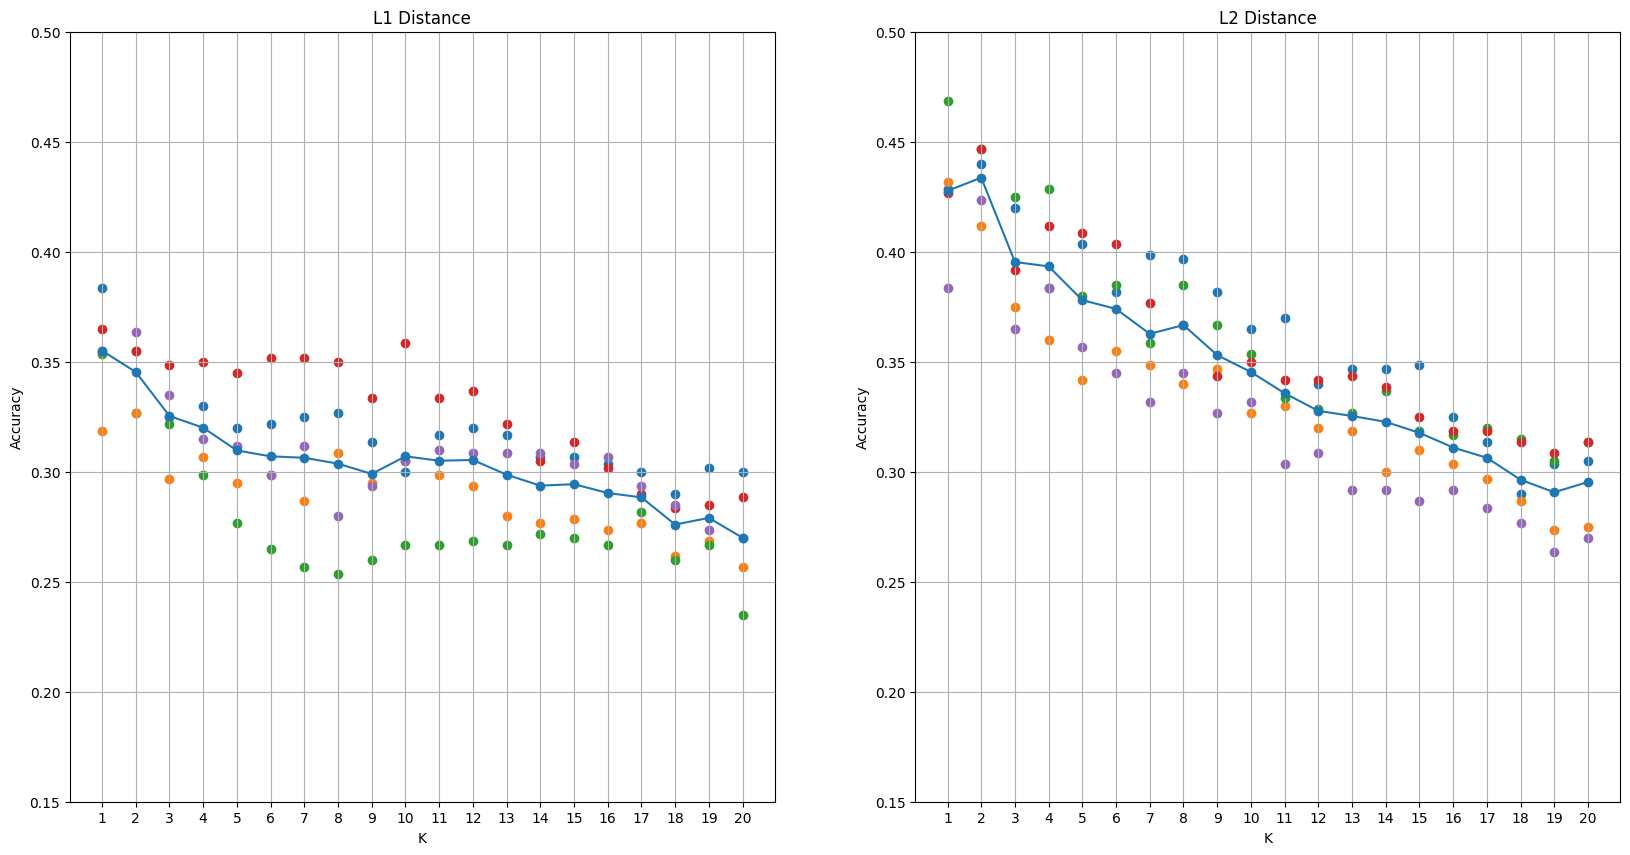

In [81]:
x_list = list(range(1, k_range+1))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)

for fold in accuracies:
    y_list = fold[0]
    plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
    arr.append([fold[0][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend, fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.15, 0.5)

plt.subplot(1,2,2)
for fold in accuracies:
    y_list = fold[1]
    plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
    arr.append([fold[1][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend, fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.15, 0.5)
plt.show()

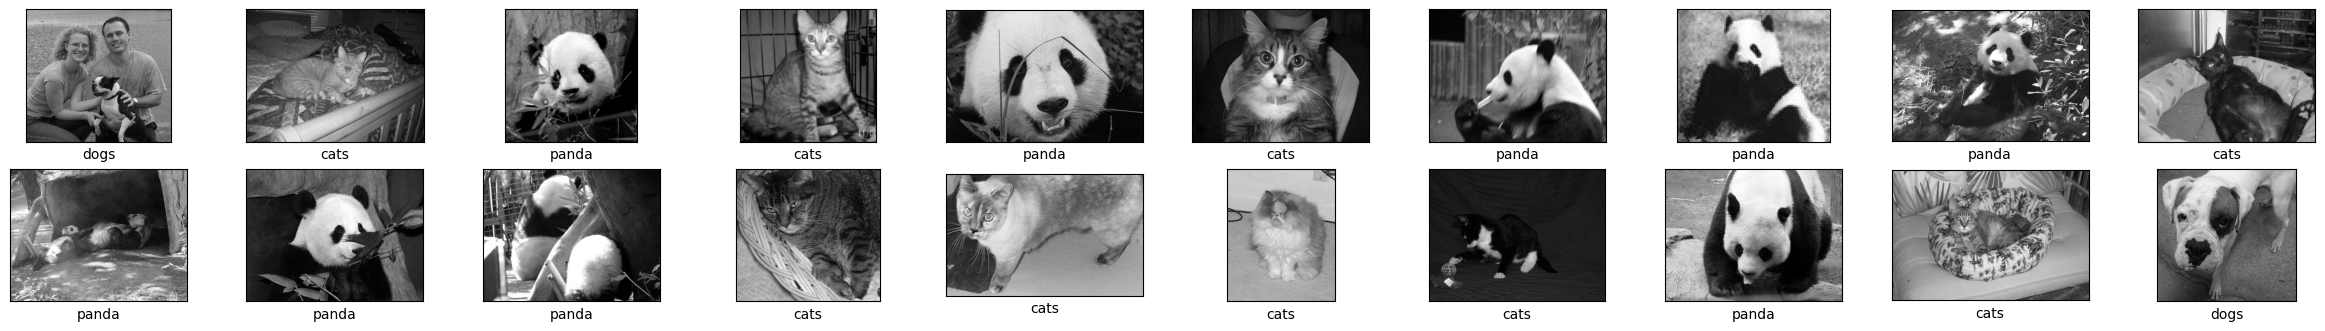

In [85]:
random.shuffle(training_data)
test_images = []

plt.figure(figsize=(30, 10))
for i in range(20):
    plt.subplot(5, 10, i+1)
    image = training_data[i][0]
    if image is not None:  # Only process valid images
        test_images.append([image, categories[training_data[i][1]]])
        plt.imshow(image, cmap="gray")
        plt.xlabel(categories[training_data[i][1]])
        plt.xticks([])
        plt.yticks([])
plt.show()